# Summer School Ideas


In [1]:
!apt update
!apt install -y openjdk-17-jdk-headless
!pip install pathling==7.2.0 deltalake==0.25.4 pandas==2.2.2 polars==1.26.0

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Intro gemeinsam

In [4]:
from pathling import PathlingContext, Expression as exp
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.config(
        "spark.jars.packages",
        "au.csiro.pathling:library-runtime:6.4.2,"
        "io.delta:delta-core_2.12:2.4.0,"
        "org.apache.hadoop:hadoop-aws:3.3.4",
    )
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config(
        "spark.sql.catalog.spark_catalog",
        "org.apache.spark.sql.delta.catalog.DeltaCatalog",
    )
    .config(
        "spark.hadoop.fs.s3a.endpoint",
        "rook-ceph-rgw-ceph-nvme-object.storage-ceph-nvme.svc",
    )
    .config("spark.pathling.encoding.enableExtensions", "true")
    .config("spark.pathling.fhirPath.allowExtensions", "true")
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "10g")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.signing-algorithm", "S3SignerType")
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    # .config("spark.hadoop.fs.s3a.committer.name", "magic")
    # .config("spark.hadoop.fs.s3a.committer.magic.enabled", "true")
    .getOrCreate()
)

spark.sparkContext.setCheckpointDir("/tmp")

pc = PathlingContext.create(spark,
                            enable_delta=True,
                            enable_extensions=True)


25/06/04 17:28:30 WARN SimpleFunctionRegistry: The function date_diff replaced a previously registered function.


In [32]:
from pathling import Expression as exp
from pyspark.sql.functions import col, regexp_replace

In [9]:
### Load Patient Data
# Wir laden die einzelnen FHIR-Bundles in eine Pathling data source

# !!Vorher müssen die json-Files in den Ordner data/ hier in die Laufzeit hochgeladen werden!!
# TO DO: curl repo and download images here

data = pc.read.bundles(
    "./data", ["Patient", "Condition", "Observation", "Procedure"]
)

In [10]:
data

_______________________________________________________________________

# MII Resourcen - Erweiterungsmodul Onkologie
## Implementation Guide
https://simplifier.net/guide/mii-ig-modul-onkologie-2024-de/MIIIGModulOnkologie?version=current

# THEMEN:
## 1. Extract
## 2. Combining Resource Types
### 2.1 Join 
### 2.2 Resolve 
### 2.3 ReverseResolve
________________________________________________________________________

# 1. Extract

## PATIENT -- RESOURCENTYP: PATIENT
https://www.medizininformatik-initiative.de/Kerndatensatz/Modul_Person_Version_2/MIIIGModulPerson-TechnischeImplementierung-FHIR-Profile-PseudonymisiertePatientinPatient.html 

In [11]:
### Extract Patient Data

# Wir nutzen `extract`, um nur den Resourcentyp Patient aus der Pathling datasource zu extrahieren und in einen Pyspark Dataframe zu laden
# mithilfe von FHIR Path Ausdrücken können wir in Arrays verschachtelte FHIR Elemente "ausklappen" und als Spalte darstellen
# exp("<FHIR Path Ausdruck>", "<Spaltenname>")

# Dabei extrahieren wir:
# - die einmalige FHIR Resource ID für jede Patientenresource
# - die pseudonymisierte Patienten-ID
# - das Geschlecht
# - das Geburtsdatum
# - das Sterbedatum

patients = data.extract(
    "Patient",
    columns=[
        exp("id", "patient_resource_id"),
        exp("identifier.value", "patid_pseudonym"),
        exp("gender", "gender"),
        exp("birthDate", "birth_date"),
        exp("deceasedDateTime", "deceased_datetime"),
    ],
)

# da die extract Funktion relativ resourcenintensiv werden kann in Abhängigkeit der Datenmenge, und da Spark "lazy" agiert, lohnt es sich hier Spark Checkpoint einzusetzen
# "lazy" bedeutet, dass Spark alle Befehle in einer To Do Liste sammelt und erst nach einer "Action" ausführt.
# Außerdem speichert Spark keinen materialisierten Zwischenstand des dataframes, wenn man das nicht ausdrücklich verlangt
# mithilfe des Checkpoints können wir einen solchen Zwischenstand des dataframes zwischenspeichern und verhindern somit, dass Spark dieselben Schritte immer wieder ausführt
# das "count" brauchen wir hier als Action, damit auch der checkpoint sofort ausgeführt wird und nicht aufgrund der "laziness" in die To Do Liste wandert
# mithilfe von spark.sparkContext.setCheckpointDir() können wir den Speicherort der Checkpoints festlegen

patients = patients.checkpoint(eager=True)
patients_count = patients.count() # enforce checkpoint

print(patients_count)

25/06/04 17:30:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


72


In [16]:
patients.show(72)

+-------------------+----------------+------+----------+-----------------+
|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|
+-------------------+----------------+------+----------+-----------------+
|   ab0f1ed341372001|2b652c00c32a7f23|  male|1965-07-29|             NULL|
|   5cc1af2309e29e00|ed9dc76fe9f770f2|  male|1955-11-23|             NULL|
|   e33a2618c6e1a606|0475687e595c4b7b|female|1954-10-13|             NULL|
|   befae30c74019b1c|e6453cef780335f7|  male|1955-12-28|             NULL|
|   437e8f9eae081c75|fc10ae29d9fa0a14|  male|1948-04-06|             NULL|
|   cc2d75349812f146|03dce5400ee975cd|  male|1939-01-26|             NULL|
|   4f7b657ae62cb1f0|e585243ed4c6ba5b|female|1943-11-05|             NULL|
|   9a79159bda44a2de|7c0adc238acd5789|  male|1993-01-19|             NULL|
|   8e10679922d50f99|525435898cd242fd|  male|1954-02-04|             NULL|
|   1e2fd734cf35cf44|c407872dea98a2b9|  male|1949-11-15|             NULL|
|   68a0e992e0d91698|2655

In [ ]:
# good practice: immer die Gesamtanzahl im Auge behalten
# weil: potentiell explosionsartiges Duplizieren
# z.B. mit count distinct resource ids --> manchmal kann ein zu ungenau spezifiziertes extract der Arrays dazu führen, dass durch das Aufklappen eines Arrays
# mit mehr als einem Element mehrere Zeilen pro Patient (oder Diagnose, etc) erzeugt werden
patients.select("patient_resource_id").distinct().count()

72

In [18]:
# Übung: Wieviele Patient*innen unserer Kohorte sind verstorben und wieviele leben noch?

## LÖSUNG:
verstorben = patients.filter(col("deceased_datetime").isNotNull()).count()
lebend = patients.filter(col("deceased_datetime").isNull()).count()

print("Verstorben:", verstorben, ", lebend:", lebend)

Verstorben: 5 , lebend: 67


## PRIMAERDIAGNOSE -- RESOURCENTYP: CONDITION
https://simplifier.net/guide/mii-ig-modul-onkologie-2024-de/MIIIGModulOnkologie/TechnischeImplementierung/FHIR-Profile/Diagnose/Diagnose-Condition.page.md?version=current

In [19]:
# wir extrahieren alle Diagnosen - jede Diagnose hat eine eindeutige ID
# wieviele eindeutige Diagnosen haben wir?

conditions = data.extract("Condition",
                         columns=[
                             exp("id", "condition_resource_id"),
                         ],
                                )
conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count() # enforce checkpoint

print(conditions_count)

72


In [20]:
# good practice: count distinct ids
conditions.select("condition_resource_id").distinct().count()

72

In [21]:
conditions = data.extract("Condition",
                        columns=[
                            exp("id", "condition_resource_id"),
                            exp("code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code", "icd10_code"),
                        ],
                    )

conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count() # enforce checkpoint

print(conditions_count)

72


In [22]:
# oder filter
conditions = data.extract("Condition",
                        columns=[
                            exp("id", "condition_resource_id"),
                            exp("code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code.first()", "icd10_code"),
                        ],
                        filters=[
                            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()"
                        ]
                    )

conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count() # enforce checkpoint

print(conditions_count)

72


In [44]:
# die duplikation entsteht erst wenn extension auf condition ebene hinzukommt zum
# framework macht intern einen cross join
conditions = data.extract("Condition",
                        columns=[
                            exp("id", "condition_resource_id"),
                            exp("code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code", "icd10_code"), # kardinalität 0...1
                            exp("extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime", "date_diagnosis"), # kardinalität 1..1
                        ],
                        filters=[
                            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()",
                            # nicht gut - es gibt welche ohne datum
                            #"extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.exists()" # ersetzt leider nicht das first()
                        ]
                    )

conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count() # enforce checkpoint

print("falscher count: ", conditions_count)

falscher count:  144


In [45]:
conditions.select("condition_resource_id").distinct().count()

72

In [46]:
conditions.show()

+---------------------+----------+--------------+
|condition_resource_id|icd10_code|date_diagnosis|
+---------------------+----------+--------------+
|     6b612dd173fa5544|     C18.0|    2023-08-20|
|     6b612dd173fa5544|     C18.0|          NULL|
|     d80a996d35bb0d68|     C18.2|    2024-06-19|
|     d80a996d35bb0d68|     C18.2|          NULL|
|     e72e5f5440a7ffc5|     C25.0|    2022-07-06|
|     e72e5f5440a7ffc5|     C25.0|          NULL|
|     f4fe8697f1dff2db|     C25.0|    2023-08-08|
|     f4fe8697f1dff2db|     C25.0|          NULL|
|     6961f769aab1b8cd|     C15.5|    2022-11-09|
|     6961f769aab1b8cd|     C15.5|          NULL|
|     08405c94eb7dc213|     C15.9|    2023-11-24|
|     08405c94eb7dc213|     C15.9|          NULL|
|     96fe81bd47dd30e1|     C25.0|    2018-01-23|
|     96fe81bd47dd30e1|     C25.0|          NULL|
|     bba49ef6a65e1746|     C25.1|    2023-10-06|
|     bba49ef6a65e1746|     C25.1|          NULL|
|     b6d5a69ce456abf0|     C15.5|    2024-05-13|


In [26]:
# wir brauchen da ein first wo wir sicher sind, dass es nur einmal vorkommen kann
conditions = data.extract("Condition",
                        columns=[
                            exp("id", "condition_resource_id"),
                            exp("code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code.first()", "icd10_code"), # kardinalität 0...1
                            exp("extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.first()", "date_diagnosis"), # kardinalität 1..1
                            exp("recordedDate", "recorded_date"),
                        ],
                        filters=[
                            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()",
                            # nicht gut - es gibt welche ohne datum
                            #"extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.exists()" # ersetzt leider nicht das first()
                        ]
                    )

conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count() # enforce checkpoint

print(conditions_count)

72


In [27]:
conditions.show(72)

+---------------------+----------+--------------+-------------+
|condition_resource_id|icd10_code|date_diagnosis|recorded_date|
+---------------------+----------+--------------+-------------+
|     051e5a0e019c30ce|     C18.3|    2024-03-04|   2025-01-26|
|     07d2b410e5cfbe5f|     C15.4|    2024-09-28|   2024-11-02|
|     08405c94eb7dc213|     C15.9|    2023-11-24|   2024-08-03|
|     08e306e6917943c2|     C15.4|    2024-02-29|   2024-08-17|
|     09fc5566cf6f17ad|     C18.0|    2024-04-23|   2024-08-03|
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|   2024-10-27|
|     0f8531c4327ebbd2|     C18.7|    2024-06-21|   2024-09-02|
|     15c02d0d9eb2c08c|     C71.0|    2024-01-05|   2024-12-21|
|     1d3fcafbde7a3d24|     C18.0|    2024-08-15|   2024-08-15|
|     1ee93bb69d5a0f4f|     C71.5|    2024-07-16|   2024-09-21|
|     1f080c26891c70a0|     C18.0|    2023-02-11|   2024-09-03|
|     237e4fb6ac5a7cc7|     C18.1|    2021-09-25|   2024-08-22|
|     24024157215224ee|     C15.4|    20

In [28]:
# Referenz zum Patienten
conditions = data.extract("Condition",
                        columns=[
                            exp("id", "condition_resource_id"),
                            exp("code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code.first()", "icd10_code"), # kardinalität 0...1
                            exp("extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.first()", "date_diagnosis"), # kardinalität 1..1
                            exp("subject.reference", "condition_subject_reference"),
                        ],
                        filters=[
                            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()"
                        ]
                    )

conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count() # enforce checkpoint

print(conditions_count)

72


# 2. COMBINING RESOURCE TYPES
## 2.1 Join

In [47]:
# die Resource Condition hat eine Referenz zur Resource Patient in "condition_subject_reference", die der patient_resource_id entspricht
# wir können also wie folgt joinen: patients["patient_resource_id"] == conditions["condition_subject_reference"]
# vorher müssen wir jedoch noch einen Vorverarbeitungsschritt ausführen - welchen?


In [29]:
conditions.show()

+---------------------+----------+--------------+---------------------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|
+---------------------+----------+--------------+---------------------------+
|     051e5a0e019c30ce|     C18.3|    2024-03-04|       Patient/e5c41057a...|
|     07d2b410e5cfbe5f|     C15.4|    2024-09-28|       Patient/ab0f1ed34...|
|     08405c94eb7dc213|     C15.9|    2023-11-24|       Patient/eb9728de5...|
|     08e306e6917943c2|     C15.4|    2024-02-29|       Patient/21560e655...|
|     09fc5566cf6f17ad|     C18.0|    2024-04-23|       Patient/0fae573b1...|
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|       Patient/61ed44a22...|
|     0f8531c4327ebbd2|     C18.7|    2024-06-21|       Patient/b90e420a6...|
|     15c02d0d9eb2c08c|     C71.0|    2024-01-05|       Patient/64ffc8f6e...|
|     1d3fcafbde7a3d24|     C18.0|    2024-08-15|       Patient/e6f48bd3b...|
|     1ee93bb69d5a0f4f|     C71.5|    2024-07-16|       Patient/

In [30]:
# Vergleich condition_subject_reference zu patient_resource_id -- wo ist der Unterschied?
patients.show()

+-------------------+----------------+------+----------+-----------------+
|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|
+-------------------+----------------+------+----------+-----------------+
|   ab0f1ed341372001|2b652c00c32a7f23|  male|1965-07-29|             NULL|
|   5cc1af2309e29e00|ed9dc76fe9f770f2|  male|1955-11-23|             NULL|
|   e33a2618c6e1a606|0475687e595c4b7b|female|1954-10-13|             NULL|
|   befae30c74019b1c|e6453cef780335f7|  male|1955-12-28|             NULL|
|   437e8f9eae081c75|fc10ae29d9fa0a14|  male|1948-04-06|             NULL|
|   cc2d75349812f146|03dce5400ee975cd|  male|1939-01-26|             NULL|
|   4f7b657ae62cb1f0|e585243ed4c6ba5b|female|1943-11-05|             NULL|
|   9a79159bda44a2de|7c0adc238acd5789|  male|1993-01-19|             NULL|
|   8e10679922d50f99|525435898cd242fd|  male|1954-02-04|             NULL|
|   1e2fd734cf35cf44|c407872dea98a2b9|  male|1949-11-15|             NULL|
|   68a0e992e0d91698|2655

In [ ]:
# entferne das "Patient/" in den Werten der Spalte "condition_subject_reference", da dieser Präfix in patient_resource_id auch nicht vorkommt

conditions = conditions.withColumn(
    "condition_subject_reference",
    regexp_replace("condition_subject_reference", "^Patient/", "")
)
conditions = conditions.checkpoint(eager=True)
conditions.count() # enforce checkpoint

72

In [34]:
conditions.show()

+---------------------+----------+--------------+---------------------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|
+---------------------+----------+--------------+---------------------------+
|     051e5a0e019c30ce|     C18.3|    2024-03-04|           e5c41057a1b66cda|
|     07d2b410e5cfbe5f|     C15.4|    2024-09-28|           ab0f1ed341372001|
|     08405c94eb7dc213|     C15.9|    2023-11-24|           eb9728de512f00ec|
|     08e306e6917943c2|     C15.4|    2024-02-29|           21560e6558e3bce2|
|     09fc5566cf6f17ad|     C18.0|    2024-04-23|           0fae573b17cb69e5|
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|           61ed44a223187661|
|     0f8531c4327ebbd2|     C18.7|    2024-06-21|           b90e420a6b680c0d|
|     15c02d0d9eb2c08c|     C71.0|    2024-01-05|           64ffc8f6e2a04bf5|
|     1d3fcafbde7a3d24|     C18.0|    2024-08-15|           e6f48bd3bc9800c8|
|     1ee93bb69d5a0f4f|     C71.5|    2024-07-16|           3875

In [35]:
patients_conditions = patients.alias("p").join(
    conditions.alias("c"),
    patients["patient_resource_id"] == conditions["condition_subject_reference"],  # Join condition
    "left"  # Left join
).select("c.*", "p.*")

patients_conditions = patients_conditions.checkpoint(eager=True)
patients_conditions_count = patients_conditions.count()
patients_conditions_count

72

In [36]:
patients_conditions.show(2)

+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|           61ed44a223187661|   61ed44a223187661|bc1a1b4fe47fdb71|  male|1949-04-29|             NULL|
|     051e5a0e019c30ce|     C18.3|    2024-03-04|           e5c41057a1b66cda|   e5c41057a1b66cda|6d85de25529cff53|  male|1939-06-28|             NULL|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
only showing top 2 rows



## 2.2 Resolve

In [37]:
# deutlich schlankere Alternative zu zwei einzelnen extracts von patients und conditions und join
# resolve löst Referenz auf

conditions_patients_resolve = data.extract("Condition",
                         columns=[
                             exp("id", "condition_resource_id"),
                             exp("code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code.first()", "icd10_code"), # kardinalität 0...1
                             exp("extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.first()", "date_diagnosis"), # kardinalität 1..1
                             exp("subject.reference", "condition_subject_reference"),

                             exp("subject.resolve().ofType(Patient).id", "patient_resource_id"),
                             exp("subject.resolve().ofType(Patient).identifier.value", "patid_pseudonym"),
                             exp("subject.resolve().ofType(Patient).birthDate", "birth_date"),
                             exp("subject.resolve().ofType(Patient).gender", "gender"),
                             exp("subject.resolve().ofType(Patient).deceasedDateTime", "deceased_datetime"),
                         ],
                        filters=[
                            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()"
                        ]
                                )
conditions_patients_resolve = conditions_patients_resolve.checkpoint(eager=True)
conditions_patients_resolve_count = conditions_patients_resolve.count()
conditions_patients_resolve_count

72

In [38]:
conditions_patients_resolve.show()

+---------------------+----------+--------------+---------------------------+-------------------+----------------+----------+------+-----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id| patid_pseudonym|birth_date|gender|deceased_datetime|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+----------+------+-----------------+
|     b28d21fb5d6a4bc8|     C25.0|    2019-03-07|       Patient/733b6df2a...|   733b6df2aeaaff06|897acc358f405500|1935-08-21|female|       2019-06-25|
|     6b612dd173fa5544|     C18.0|    2023-08-20|       Patient/60271b372...|   60271b372396f53a|2f4017ec9a0d48c3|1954-06-30|female|       2024-07-25|
|     e72e5f5440a7ffc5|     C25.0|    2022-07-06|       Patient/114b17715...|   114b17715cd8962f|7a258cbfec3c558c|1948-12-06|  male|       2023-11-10|
|     96fe81bd47dd30e1|     C25.0|    2018-01-23|       Patient/9ba79939e...|   9ba79939ecbcae

## 2.3 ReverseResolve

In [39]:
# löst Referenz rückwarts auf

patients_condition_reverse_resolve = data.extract("Patient",
                                columns=[
                                    exp("id", "patient_resource_id"),
                                    exp("identifier.value", "patid_pseudonym"),
                                    exp("gender", "gender"),
                                    exp("birthDate", "birth_date"),
                                    exp("deceasedDateTime", "deceased_datetime"),

                                    exp("id", "condition_resource_id"),
                                    exp("reverseResolve(Condition.subject).code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code.first()", "icd10_code"), # kardinalität 0...1
                                    exp("reverseResolve(Condition.subject).extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.first()", "date_diagnosis"), # kardinalität 1..1
                                    exp("reverseResolve(Condition.subject).subject.reference", "condition_subject_reference"),
                            ],
                        )

patients_condition_reverse_resolve = patients_condition_reverse_resolve.checkpoint(eager=True)
patients_condition_reverse_resolve_count = patients_condition_reverse_resolve.count()
patients_condition_reverse_resolve_count

25/06/04 17:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1178.0 KiB


72

In [42]:
patients_condition_reverse_resolve.show()

+-------------------+----------------+------+----------+-----------------+---------------------+----------+--------------+---------------------------+
|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|
+-------------------+----------------+------+----------+-----------------+---------------------+----------+--------------+---------------------------+
|   64ffc8f6e2a04bf5|1f8367d0b53064c2|  male|1940-06-22|       2024-04-16|     64ffc8f6e2a04bf5|     C71.0|    2024-01-05|       Patient/64ffc8f6e...|
|   114b17715cd8962f|7a258cbfec3c558c|  male|1948-12-06|       2023-11-10|     114b17715cd8962f|     C25.0|    2022-07-06|       Patient/114b17715...|
|   733b6df2aeaaff06|897acc358f405500|female|1935-08-21|       2019-06-25|     733b6df2aeaaff06|     C25.0|    2019-03-07|       Patient/733b6df2a...|
|   60271b372396f53a|2f4017ec9a0d48c3|female|1954-06-30|       2024-07-25|     60271b372396f53

## 3 Lösungswege für dasselbe Ergebnis

In [ ]:
# 1)
print("aus join")
patients_conditions.show(2)

# 2)
print("aus resolve:")
conditions_patients_resolve.show(2)

#3
print("aus reverseResolve:")
patients_condition_reverse_resolve.show(2)

aus join
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|           61ed44a223187661|   61ed44a223187661|bc1a1b4fe47fdb71|  male|1949-04-29|             null|
|     051e5a0e019c30ce|     C18.3|    2024-03-04|           e5c41057a1b66cda|   e5c41057a1b66cda|6d85de25529cff53|  male|1939-06-28|             null|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
only showing top 2 rows

aus resolve:
+---------------------+----------+-------------

In [ ]:
### ÜBUNG: Altersverteilung der onkologischen Patient:innen

# 1.1 Berechne das Alter bei Diagnose aus dem Geburtsdatum und Diagnosedatum und füge es als neue Spalte in den DataFrame ein
# Hinweis: diese Funktionen sind hilfreich: withColumn,
from pyspark.sql.functions import col, datediff, floor, to_date



# 1.2 Zeichne ein Histogramm der Altersverteilung - wenn du mit matplotlib zeichnen möchtest, Daten in Pandas überführen
import matplotlib.pyplot as plt



+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|age_at_diagnosis|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+----------------+
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|           61ed44a223187661|   61ed44a223187661|bc1a1b4fe47fdb71|  male|1949-04-29|             NULL|              73|
|     051e5a0e019c30ce|     C18.3|    2024-03-04|           e5c41057a1b66cda|   e5c41057a1b66cda|6d85de25529cff53|  male|1939-06-28|             NULL|              84|
|     252eb9211bc1b339|     C71.2|    2024-07-14|           07ec02b49e0b7aba|   07ec02b49e0b7aba|02024496e0b0bbd0|  male|1952-07-26|             NULL|          

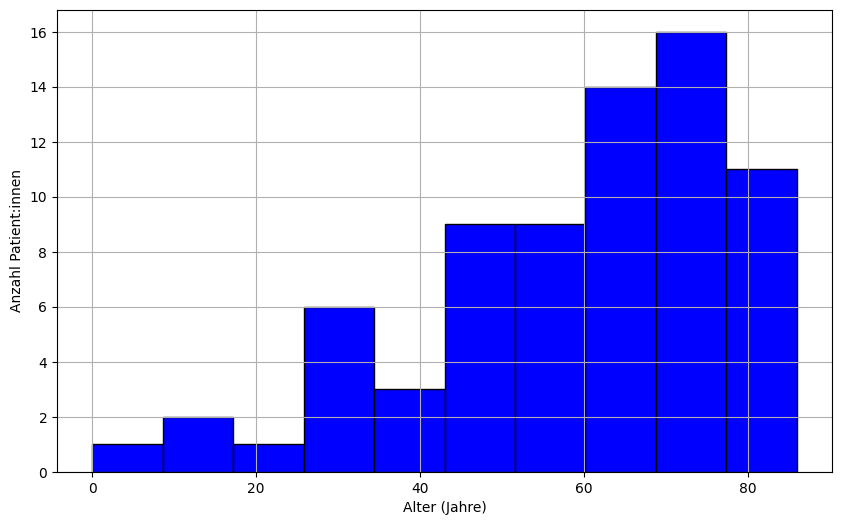

In [48]:
### LÖSUNG: Altersverteilung der onkologischen Patient:innen

# 1.1 Berechne das Alter bei Diagnose aus dem Geburtsdatum und Diagnosedatum und füge es als neue Spalte in den DataFrame ein
# Hinweis: diese Funktionen sind hilfreich: withColumn,
from pyspark.sql.functions import col, datediff, floor, to_date

patients_conditions = patients_conditions.withColumn(
    "birth_date", to_date(col("birth_date"))
).withColumn(
    "age_at_diagnosis", floor(datediff(col("date_diagnosis"), col("birth_date")) / 365.25)
)

patients_conditions.show(72)

# 1.2 Zeichne ein Histogramm der Altersverteilung - ggf. Daten in Pandas überführen
import matplotlib.pyplot as plt

patients_conditions_pd = patients_conditions.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(patients_conditions_pd["age_at_diagnosis"].dropna(), bins=10, edgecolor="black", color="blue")
plt.xlabel("Alter (Jahre)")
plt.ylabel("Anzahl Patient:innen")
plt.grid(True)
plt.show()

## danach: Gruppenarbeiten
## 4 Entitäten in Gruppen analysieren
## ggf. Therapien mit einbeziehen